In [1]:
#Libraries
from __future__ import print_function
import numpy as np
from imageio import imread

import torch
import torch.nn
from torchvision.models.vgg import vgg19
import numpy as np
from sporco.util import tikhonov_filter
from PIL import Image
import torch
from torchvision.models.vgg import vgg19
import matplotlib.pyplot as plt

from typing import List
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from PIL import Image

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#load images
gray = imread('data/test/visible/190010.jpg')
ir = imread('data/test/infrared/190010.jpg')


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def lowpass(s, lda, npad):
    return tikhonov_filter(s, lda, npad)

def c3(s):
    if s.ndim == 2:
        s3 = np.dstack([s, s, s])
    else:
        s3 = s
    return np.rollaxis(s3, 2, 0)[None, :, :, :]

def l1_features(out):
    h, w, d = out.shape
    A_temp = np.zeros((h+2, w+2))
    
    l1_norm = np.sum(np.abs(out), axis=2)
    A_temp[1:h+1, 1:w+1] = l1_norm
    return A_temp

In [4]:
#fusion strategy

def fusion_strategy(feat_a, feat_b, source_a, source_b, unit):
    
    m, n = feat_a.shape
    m1, n1 = source_a.shape[:2]
    weight_ave_temp1 = np.zeros((m1, n1))
    weight_ave_temp2 = np.zeros((m1, n1))
    
    for i in range(1, m):
        for j in range(1, n):
            A1 = feat_a[i-1:i+1, j-1:j+1].sum() / 9
            A2 = feat_b[i-1:i+1, j-1:j+1].sum() / 9
            
            weight_ave_temp1[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = A1 / (A1+A2)
            weight_ave_temp2[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = A2 / (A1+A2)

    if source_a.ndim == 3:
        weight_ave_temp1 = weight_ave_temp1[:, :, None]
    source_a_fuse = source_a * weight_ave_temp1
    if source_b.ndim == 3:
        weight_ave_temp2 = weight_ave_temp2[:, :, None]
    source_b_fuse = source_b * weight_ave_temp2
    
    if source_a.ndim == 3 or source_b.ndim == 3:
        gen = np.atleast_3d(source_a_fuse) + np.atleast_3d(source_b_fuse)
    else:
        gen = source_a_fuse + source_b_fuse
    
    return gen

def get_activation(model, layer_numbers, input_image):
    outs = []
    out = input_image
    for i in range(max(layer_numbers)+1):
        with torch.no_grad():
            out = model.features[i](out)
        if i in layer_numbers:
            outs.append(np.rollaxis(out.detach().cpu().numpy()[0], 0, 3))
    return outs



In [5]:
#Fusion 
def fuse(vis, ir, model=None):
    npad = 16
    lda = 5
    vis_low, vis_high = lowpass(vis.astype(np.float32)/255, lda, npad)
    ir_low, ir_high = lowpass(ir.astype(np.float32)/255, lda, npad)
    
    if model is None:
        model = vgg19(True)
    model.cpu().eval()
    relus = [2, 7, 12, 21]
    unit_relus = [1, 2, 4, 8]
    
    vis_in = torch.from_numpy(c3(vis_high)).cpu()
    ir_in = torch.from_numpy(c3(ir_high)).cpu()
    
    relus_vis = get_activation(model, relus, vis_in)
    relus_ir = get_activation(model, relus, ir_in)
    
    vis_feats = [l1_features(out) for out in relus_vis]
    ir_feats = [l1_features(out) for out in relus_ir]
    
    saliencies = []
    saliency_max = None
    for idx in range(len(relus)):
        saliency_current = fusion_strategy(vis_feats[idx], ir_feats[idx], vis_high, ir_high, unit_relus[idx])
        saliencies.append(saliency_current)

        if saliency_max is None:
            saliency_max = saliency_current
        else:
            saliency_max = np.maximum(saliency_max, saliency_current)
            
    if vis_low.ndim == 3 or ir_low.ndim == 3:
        low_fused = np.atleast_3d(vis_low) + np.atleast_3d(ir_low)
    else:
        low_fused = vis_low + ir_low
    low_fused = low_fused / 2
    high_fused = saliency_max
    return low_fused +  high_fused

/tmp/ipykernel_56473/1149710684.py:4: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/tmp/ipykernel_56473/1149710684.py:4: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)


Text(0.5, 1.0, 'Fusion')

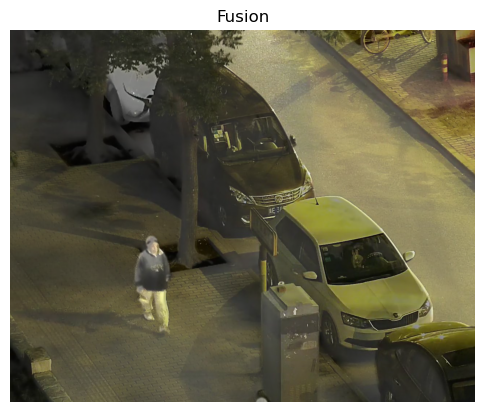

In [6]:
#fused image
plt.figure(figsize=(6, 6))
fused =  np.clip(fuse(gray, ir), 0, 1)
fused = np.rint(fused * 255).astype(np.uint8)
plt.imshow(fused, 'gray')
plt.axis('off')
plt.title('Fusion')

/tmp/ipykernel_56473/1149710684.py:4: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/tmp/ipykernel_56473/1149710684.py:4: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


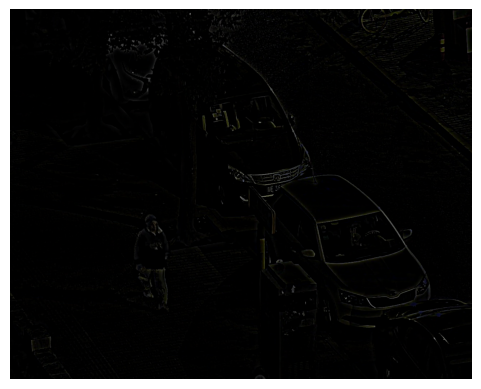

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


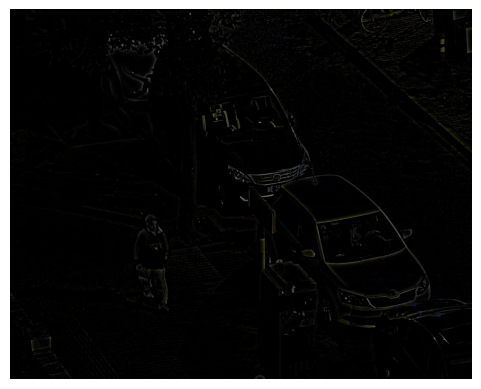

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


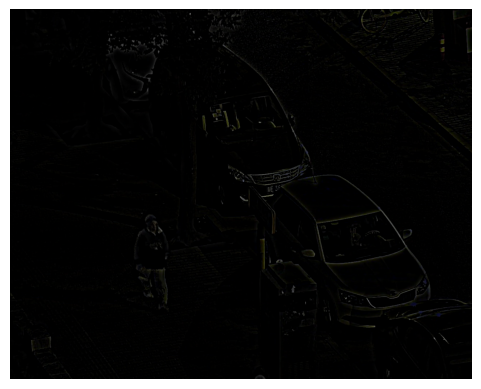

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


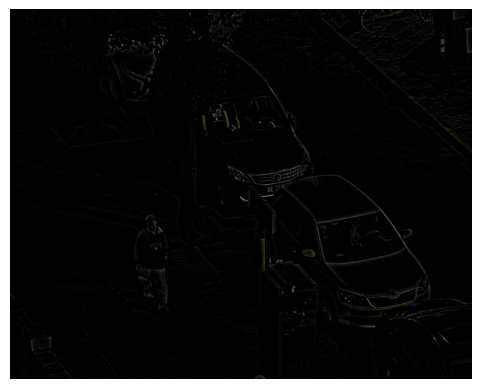

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


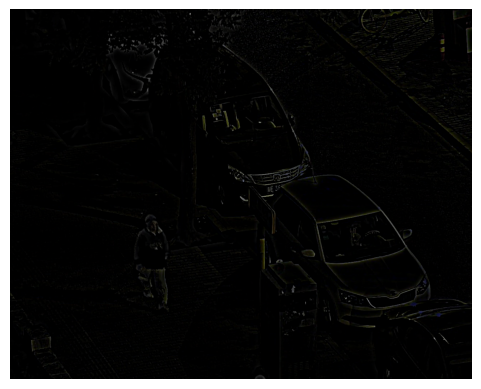

<Figure size 640x480 with 0 Axes>

In [7]:
#saliency  model
npad = 32
lda = 15
graylow, grayhigh = lowpass(gray.astype(np.float32)/255, lda, npad)
irlow, irhigh = lowpass(ir.astype(np.float32)/255, lda, npad)

grayhigh3 = c3(grayhigh)
irhigh3 = c3(irhigh)

model = vgg19(True).cpu().eval()

gray_in = torch.from_numpy(grayhigh3).cpu()
ir_in = torch.from_numpy(irhigh3).cpu()
relus = [2, 7, 12, 21]
unit_relus = [1, 2, 4, 8]

relus_gray = get_activation(model, relus, gray_in)
relus_ir = get_activation(model, relus, ir_in)

gray_feats = [l1_features(out) for out in relus_gray]
ir_feats = [l1_features(out) for out in relus_ir]

saliencies = []
saliency_max = None
for idx in range(len(relus)):
    saliency_current = fusion_strategy(gray_feats[idx], ir_feats[idx], grayhigh, irhigh, unit_relus[idx])
    saliencies.append(saliency_current)
    
    if saliency_max is None:
        saliency_max = saliency_current
    else:
        saliency_max = np.maximum(saliency_max, saliency_current)
    
    plt.imshow(saliency_current, 'gray')
    plt.axis('off')
    plt.show()

plt.imshow(saliency_max, 'gray')
plt.axis('off')
plt.show()
plt.savefig('silencymap.png', bbox_inches="tight")

/tmp/ipykernel_56473/2613896275.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


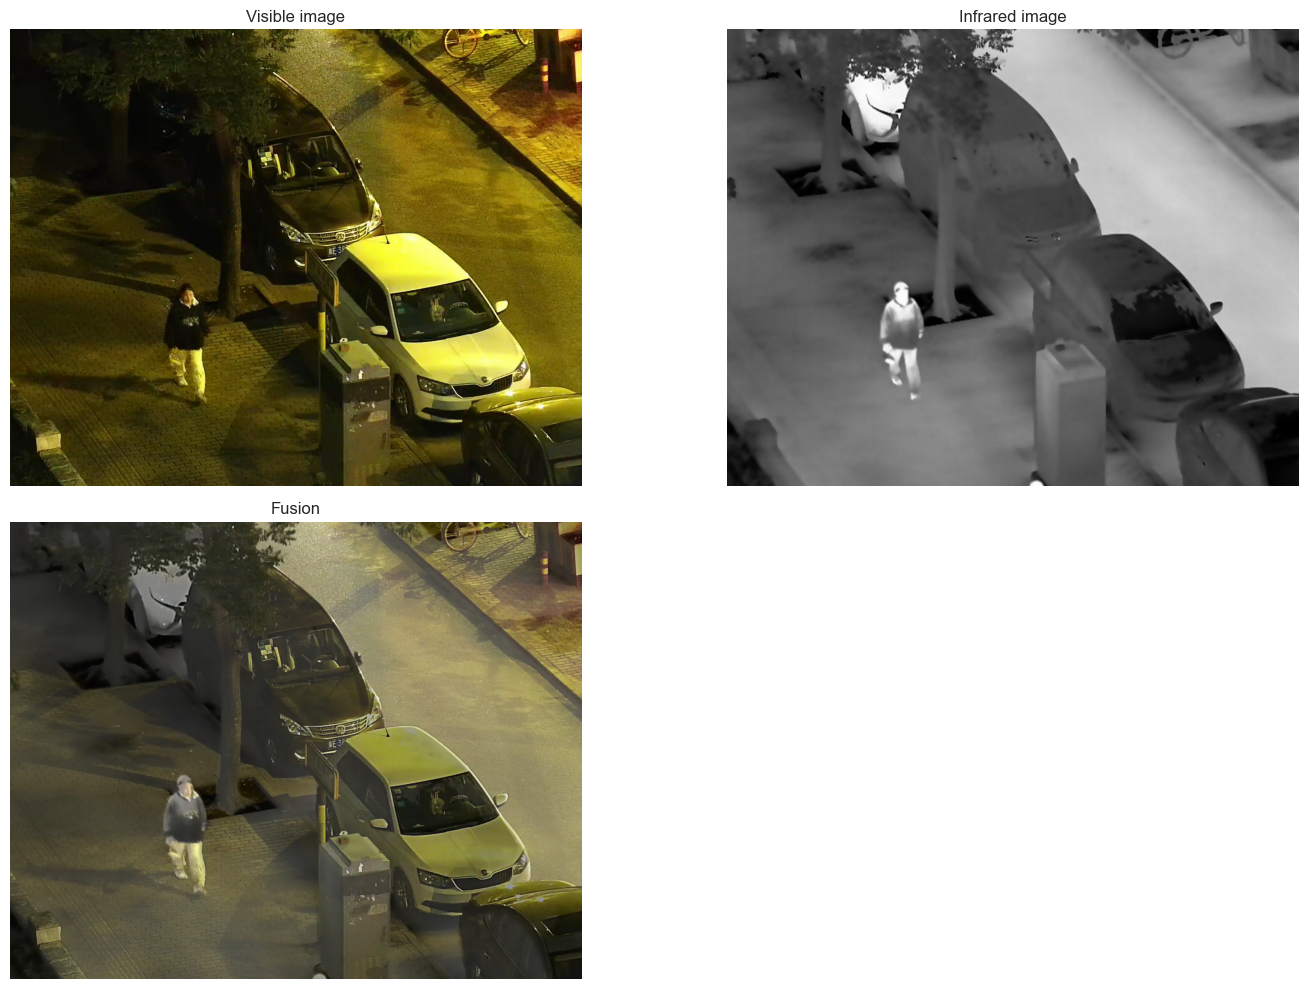

In [9]:

#Fused results
plt.style.use('seaborn-white')
plt.rcParams['savefig.dpi'] = 300
low_fused = (graylow + irlow) / 2
high_fused = saliency_max

fusion =  np.clip((low_fused + high_fused), 0, 1)
fusion = np.rint(fusion * 255).astype(np.uint8)

fig=plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(gray,  cmap='brg')
plt.axis('off')
plt.title('Visible image')

plt.subplot(2, 2, 2)
plt.imshow(ir,  cmap='brg')
plt.axis('off')
plt.title('Infrared image')

plt.subplot(2, 2, 3)
plt.imshow(fusion,  cmap='brg')
plt.axis('off')
plt.title('Fusion')
plt.savefig('fused.png', bbox_inches="tight")
plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
plt.show();